In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

<xarray.Dataset>
Dimensions:  (xh: 640, y: 640, z: 3328, time: 1)
Coordinates:
  * xh       (xh) float32 0.0 0.04279 0.08558 0.1284 ... 27.21 27.26 27.3 27.34
  * y        (y) float32 0.0214 0.06419 0.107 0.1498 ... 27.24 27.28 27.32 27.36
  * z        (z) float32 0.002716 0.008147 0.01358 0.01901 ... 18.06 18.07 18.07
  * time     (time) int32 -2147483647
Data variables:
    u        (time, z, y, xh) float32 ...
Plot spectra plot for time 616000 at height [0.2797039]
Plot spectra plot for time 616000 at height [0.8499739]
Plot spectra plot for time 616000 at height [2.0013762]
Plot spectra plot for time 616000 at height [5.9986978]
<xarray.Dataset>
Dimensions:  (x: 640, yh: 640, z: 3328, time: 1)
Coordinates:
  * x        (x) float32 0.0214 0.06419 0.107 0.1498 ... 27.24 27.28 27.32 27.36
  * yh       (yh) float32 0.0 0.04279 0.08558 0.1284 ... 27.21 27.26 27.3 27.34
  * z        (z) float32 0.002716 0.008147 0.01358 0.01901 ... 18.06 18.07 18.07
  * time     (time) int32 -2147483647


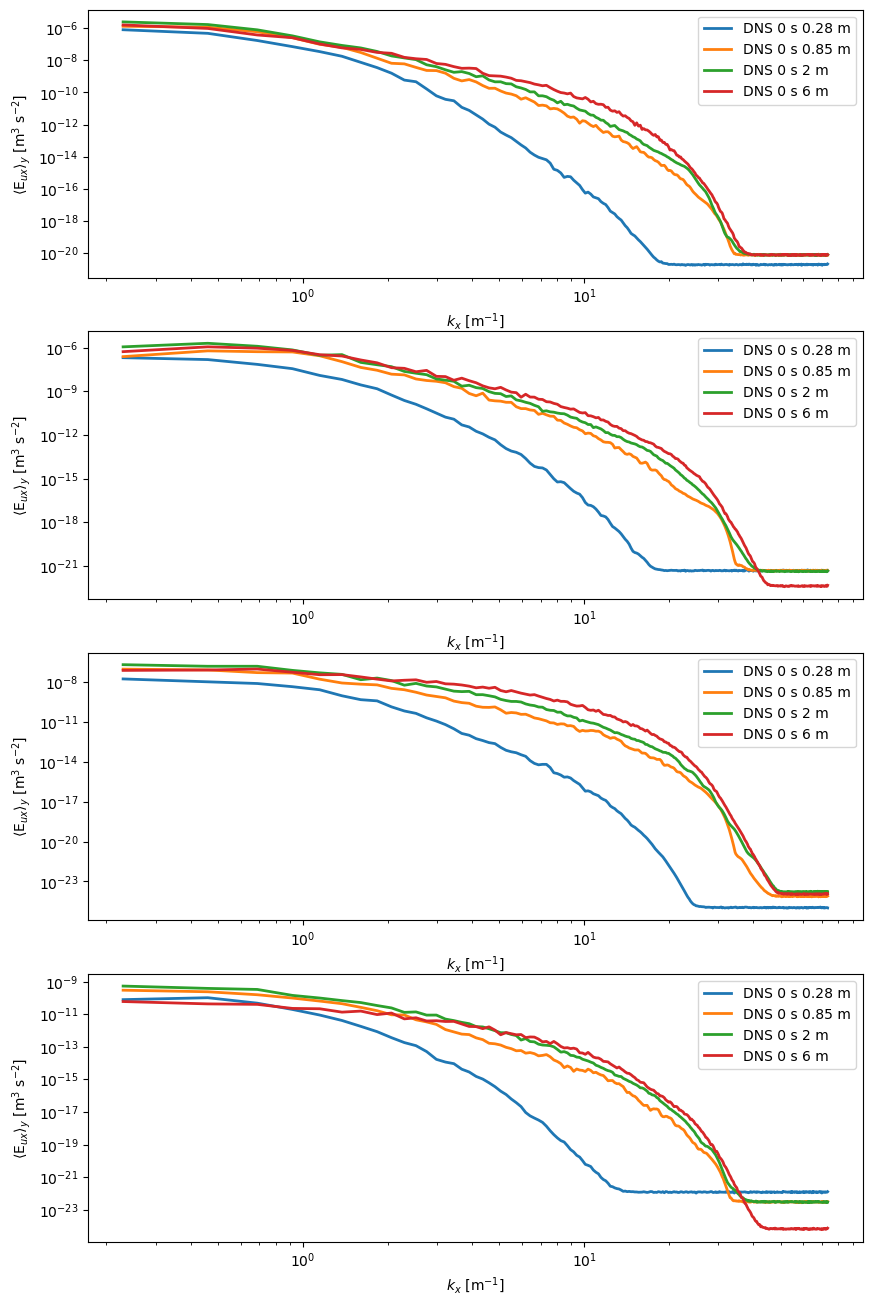

In [10]:
# var_all=['u','v','w']
# Re_all=['Re900/','Re1800/','Re2700/']
# timesteps_all=[[600000],[623000],[1377000]]
var_all=['u','v','w']
var_all=['u','v','w','b']
Re_all=['Re1800/']
# timesteps_all=[[616000,623000]]
timesteps_all=[[616000,630000]]
timesteps_all=[[616000]]
# timesteps_all=[[630000]]
hgts=[0.28,0.85,2,6]

fig,axs=plt.subplots(len(var_all),1,figsize=(10,16))
outdir=""

for ivar in range(len(var_all)):
    var=var_all[ivar]
    for iRe in range(len(Re_all)):
        Re=Re_all[iRe]
        path='/glade/u/home/adac/work/DNSdata/DNS_SBL_L320/'+Re
        timesteps=timesteps_all[iRe]
        nt=len(timesteps)

        for i in range(nt):
            
            ds = xr.open_dataset(path+var+str(timesteps[i])+'.nc',decode_times=0)
            print(ds)

            w=ds[var][0].values

            try:
              x=ds['xh'].values
            except:
              x=ds['x'].values
            nx=len(x)
            dx=np.mean(np.diff(x))

            try:
              y=ds['yh'].values
            except:
              y=ds['y'].values
            ny=len(y)

            try:
              z=ds['zh'].values
            except:
              z=ds['z'].values

            for ihgt,hgt in enumerate(hgts):
                hgt=hgts[ihgt]
                k=[(np.abs(z - hgt)).argmin()]
    
                kxy = 2*np.pi*np.fft.rfftfreq(nx,d=dx)
                dk=kxy[1] # should be smallest wavenumber 2pi/(length_fline*dx)
                lenf=len(kxy)# length_fline/2+1
                sp = np.empty([ny,lenf])
                #sp = np.empty([nF,avgt,length_yline,lenf])
                #sP = np.empty([nF,lenf])
                print('Plot spectra plot for time '+str(timesteps[i])+' at height '+str(z[k]))
                #Can make use of below loop if we want to loop through files but b/c the NBL is developping probably shouldn't
                #  for F in range(nF): # File index
                #    for i in range(avgt): # Time index
                #      for ix in range(length_fline): # x (lon) index
                #        for iy in range(length_yline): # y (lat) index
                #          Wall[F,i,ix,iy]=fsall[F][nstart+i].variables['W'][nsall[F][nstart+i]][k][(Y1+iy),(X1+ix)]
                           # Wdiag = np.array([fsall[F][nstart+i].variables['W'][nsall[F][nstart+i]][k][Y1-count,X1] for count in range(length_fline)])
                            #normalize spectra values
                #    for i in range(avgt):
                #      for iy in range(length_yline):
    
                #Different detrending options
                #N = np.linspace(0,Wall[F,i,0,iy]-Wall[F,i,-1,iy],Wall[F,i,:,iy].shape[0])
                #N = -np.mean(Wall[F,i,:,iy])
                N=0 # detrending not necessary b/c periodic BCs
                for j in range(ny):
                    sp_tmp = np.fft.rfft(w[k,j,:]+N)
                    sp[j,:] = (np.power(sp_tmp.real,2) + np.power(sp_tmp.imag,2))*dx/2.0/np.pi/nx #missing factor of two from Durran paper neccesary for the parseval's thereom to work
                    #sp[j,-1] = sp[j,-1]/2.0 #Nyquist frequency (last entry by order of reqdiag) is unique for even pts FFT, so has twice the power
                    sp[j,0] = sp[j,0]/2.0 # Calculating the 0 wavenumber, won't be plotted on a log log but just to check the assumption of zero power at zero wavenumber for different detrending methods
                    #Confirming calcs throuch Parseval's theorem
                    #wsqr=np.sum(np.power(w[k,j],2))/nx/2.0
                    #wsqr_fft=np.sum(sp[j])*dk
                    #print(wsqr,wsqr_fft)
    
                sP = np.mean(sp,axis=0)
                power = abs(sP)
    
                axs[ivar].loglog(kxy[1:],power[1:],linewidth=2,label='DNS '+str(int((timesteps[i]-timesteps[0])/10))+' s '+str(hgt)+' m')
                
        axs[ivar].legend()
        
        axs[ivar].set_ylabel(r"$\langle$E$_{ux} \rangle_y$ [m$^{3}$ s$^{-2}]$")#,fontsize=fs)
        axs[ivar].set_xlabel(r"$k_x$ [m$^{-1}$]")#,fontsize=fs)
    # ymin,ymax=axs[ivar].get_ylim()
    # kLES=kxy[-1]/np.array([4*15,4*30,4*60])*2
    # dxLES=['1.7','3.4','6.8'] # filter spacing (4*dx)
    # text_x=np.array([7.5e-1, 7e-1, 5.9e-1])*kLES
    # for ik in range(kLES.shape[0]):
    #     axs[ivar].loglog((kLES[ik],kLES[ik]),(ymin,ymax),'k--')
    #     print(2e-1*ymin)
    #     axs[ivar].text(text_x[ik],2e-1*ymin,r"$\Delta f_h=$"+dxLES[ik]+" m")
    # axs[ivar].tick_params('x', length=10, which='major')    

In [11]:
# del(fig,axs)
# fig,axs=plt.subplots(len(var_all),1,figsize=(10,16))
# hgt=5

<xarray.Dataset>
Dimensions:  (time: 1, z: 32, y: 16, xh: 16)
Coordinates:
  * time     (time) float64 0.0
  * z        (z) float64 0.2824 0.8473 1.412 1.977 ... 16.1 16.66 17.23 17.79
  * y        (y) float64 0.8558 2.567 4.279 5.991 ... 21.4 23.11 24.82 26.53
  * xh       (xh) float64 0.0 1.712 3.423 5.135 ... 20.54 22.25 23.96 25.67
Data variables:
    u        (time, z, y, xh) float64 ...
Plot spectra plot for time 0 at height [0.28241944]
Plot spectra plot for time 0 at height [0.84725833]
Plot spectra plot for time 0 at height [1.97693611]
Plot spectra plot for time 0 at height [5.93080832]
<xarray.Dataset>
Dimensions:  (time: 1, z: 32, x: 16, yh: 16)
Coordinates:
  * time     (time) float64 0.0
  * z        (z) float64 0.2824 0.8473 1.412 1.977 ... 16.1 16.66 17.23 17.79
  * x        (x) float64 0.8558 2.567 4.279 5.991 ... 21.4 23.11 24.82 26.53
  * yh       (yh) float64 0.0 1.712 3.423 5.135 ... 20.54 22.25 23.96 25.67
Data variables:
    v        (time, z, yh, x) float64 ...


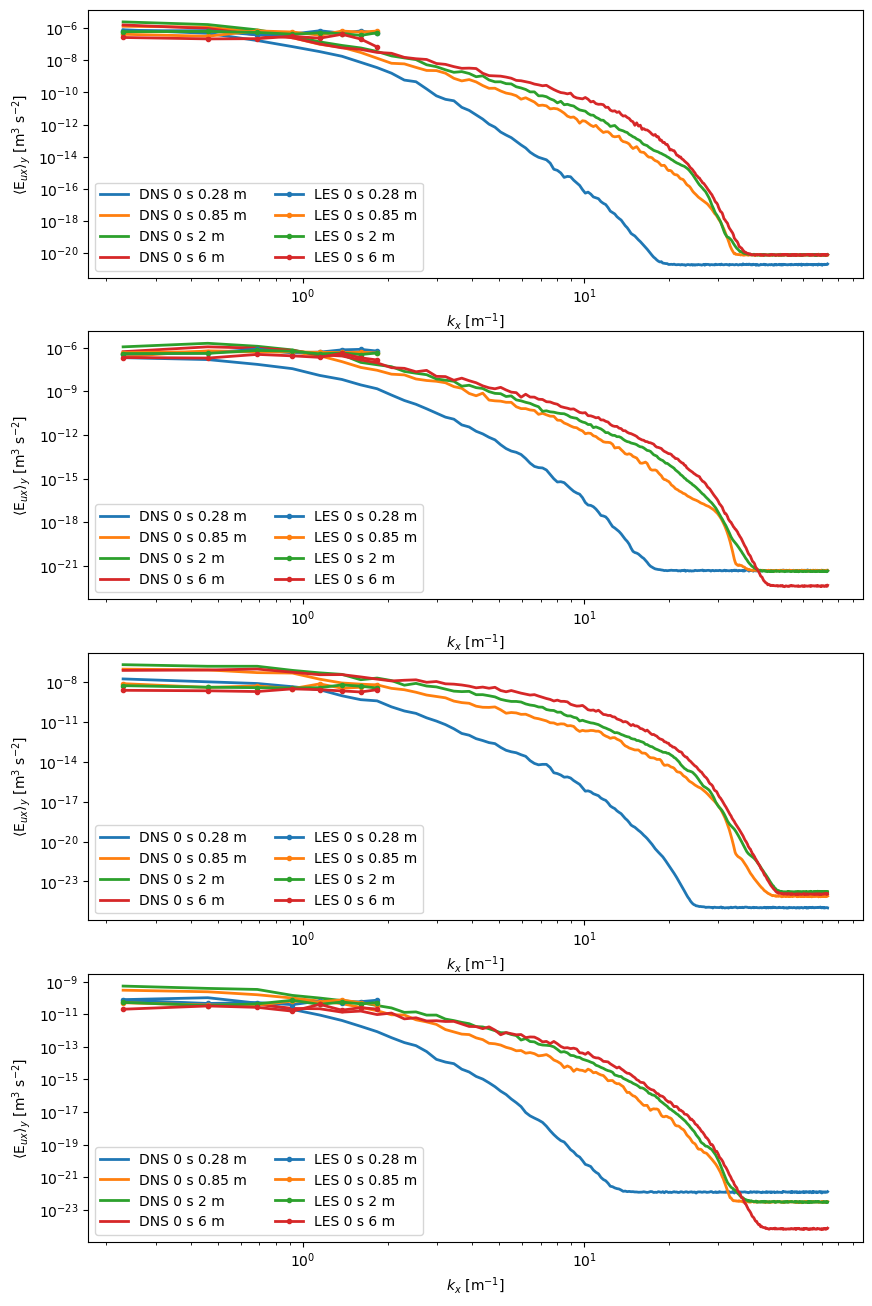

In [12]:
# paths=['/glade/u/home/adac/work/microHH/microhh_deviatoricGlobalDNN/cases/SBL_smag/','/glade/u/home/adac/work/microHH/microhh_deviatoricGlobalDNN/cases/SBL_local_filterVel_ucTKE/','/glade/u/home/adac/work/microHH/microhh_deviatoricGlobalDNN/cases/SBL_local_midGridReInterp/']
# pathLabels=['smag','Grid extrap','Re interp']#,'implcit']
# paths=['/glade/u/home/adac/work/microHH/microhh/cases/SBL_global_filterVel/','../cases/SBL_global_deviatoric_filterVel/']#,'../cases/SBL_global/']
# pathLabels=['full','deviatoric']
# paths=['../cases/SBL_local_k64_ucTKE/', '../cases/SBL_local_k64_ufTKE/']
# pathLabels=['destag','filter']
# paths=['../cases/SBL_global/']#,'../cases/SBL_global/']
# pathLabels=['full']
# paths=['../cases/SBL_global_deviatoric/','../cases/SBL_global_deviatoric_filterVel/']#,'../cases/SBL_global/']
# pathLabels=['uc','uf']
# pathLabels=['destag']
# paths=[ '/glade/u/home/adac/work/microHH/microhh/cases/SBL_global_pert/']
paths=['../cases/SBL_local_pert/']
pathLabels=['LES']
# paths=['../cases/SBL_local_filterVel_ucTKE/','../cases/SBL_local_filterVel_ufTKE/']
# pathLabels=['uc','uf']

# paths=['../cases/SBL_smag/','../cases/SBL_global_deviatoric_filterVel/','../cases/SBL_local_filterVel_ucTKE/']#,'../cases/SBL_global/']
# pathLabels=['smag','global','local']
# timesteps_all=[[0,14]]
timesteps_all=[range(0,15,7)]
timesteps_all=[[0]]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for iRe in range(len(Re_all)):
    timesteps=timesteps_all[iRe]
    for iLES in range(len(paths)):
        path=paths[iLES]
        for ivar in range(len(var_all)):

            var=var_all[ivar]
            ds = xr.open_dataset(path+var+'.nc')
            print(ds)

            Re=Re_all[iRe]
            timesteps=timesteps_all[iRe]
            nt=len(timesteps)

            for i in range(nt):
                try:
                    w=ds[var][timesteps[i]].values
                except:
                    break
                    
                try:
                  x=ds['xh'].values
                except:
                  x=ds['x'].values
                nx=len(x)
                dx=np.mean(np.diff(x))

                try:
                  y=ds['yh'].values
                except:
                  y=ds['y'].values
                ny=len(y)
    
                try:
                  z=ds['zh'].values
                except:
                  z=ds['z'].values
    
                for ihgt,hgt in enumerate(hgts):
                    hgt=hgts[ihgt]
                    color=colors[ihgt]
                    k=[(np.abs(z - hgt)).argmin()]
        
                    kxy = 2*np.pi*np.fft.rfftfreq(nx,d=dx)
                    dk=kxy[1] # should be smallest wavenumber 2pi/(length_fline*dx)
                    lenf=len(kxy)# length_fline/2+1
                    sp = np.empty([ny,lenf])
                    #sp = np.empty([nF,avgt,length_yline,lenf])
                    #sP = np.empty([nF,lenf])
                    print('Plot spectra plot for time '+str(timesteps[i])+' at height '+str(z[k]))
                    #Can make use of below loop if we want to loop through files but b/c the NBL is developping probably shouldn't
                    #  for F in range(nF): # File index
                    #    for i in range(avgt): # Time index
                    #      for ix in range(length_fline): # x (lon) index
                    #        for iy in range(length_yline): # y (lat) index
                    #          Wall[F,i,ix,iy]=fsall[F][nstart+i].variables['W'][nsall[F][nstart+i]][k][(Y1+iy),(X1+ix)]
                               # Wdiag = np.array([fsall[F][nstart+i].variables['W'][nsall[F][nstart+i]][k][Y1-count,X1] for count in range(length_fline)])
                                #normalize spectra values
                    #    for i in range(avgt):
                    #      for iy in range(length_yline):
        
                    #Different detrending options
                    #N = np.linspace(0,Wall[F,i,0,iy]-Wall[F,i,-1,iy],Wall[F,i,:,iy].shape[0])
                    #N = -np.mean(Wall[F,i,:,iy])
                    N=0 # detrending not necessary b/c periodic BCs
                    for j in range(ny):
                        sp_tmp = np.fft.rfft(w[k,j,:]+N)
                        sp[j,:] = (np.power(sp_tmp.real,2) + np.power(sp_tmp.imag,2))*dx/2.0/np.pi/nx #missing factor of two from Durran paper neccesary for the parseval's thereom to work
                        #sp[j,-1] = sp[j,-1]/2.0 #Nyquist frequency (last entry by order of reqdiag) is unique for even pts FFT, so has twice the power
                        sp[j,0] = sp[j,0]/2.0 # Calculating the 0 wavenumber, won't be plotted on a log log but just to check the assumption of zero power at zero wavenumber for different detrending methods
                        #Confirming calcs throuch Parseval's theorem
                        #wsqr=np.sum(np.power(w[k,j],2))/nx/2.0
                        #wsqr_fft=np.sum(sp[j])*dk
                        #print(wsqr,wsqr_fft)
        
                    sP = np.mean(sp,axis=0)
                    power = abs(sP)
                    
                    axs[ivar].loglog(kxy[1:],power[1:],'.-',linewidth=2,color=color,label=pathLabels[iLES]+' '+str(int(100*timesteps[i]))+' s '+str(hgt)+' m')
                            
            axs[ivar].legend(ncol=2)
            axs[ivar].set_ylabel(r"$\langle$E$_{ux} \rangle_y$ [m$^{3}$ s$^{-2}]$")#,fontsize=fs)
            axs[ivar].set_xlabel(r"$k_x$ [m$^{-1}$]")#,fontsize=fs)

# axs[0].set_ylim([1e-9,2e-8])
# axs[1].set_ylim([1e-9,7e-8])
fig

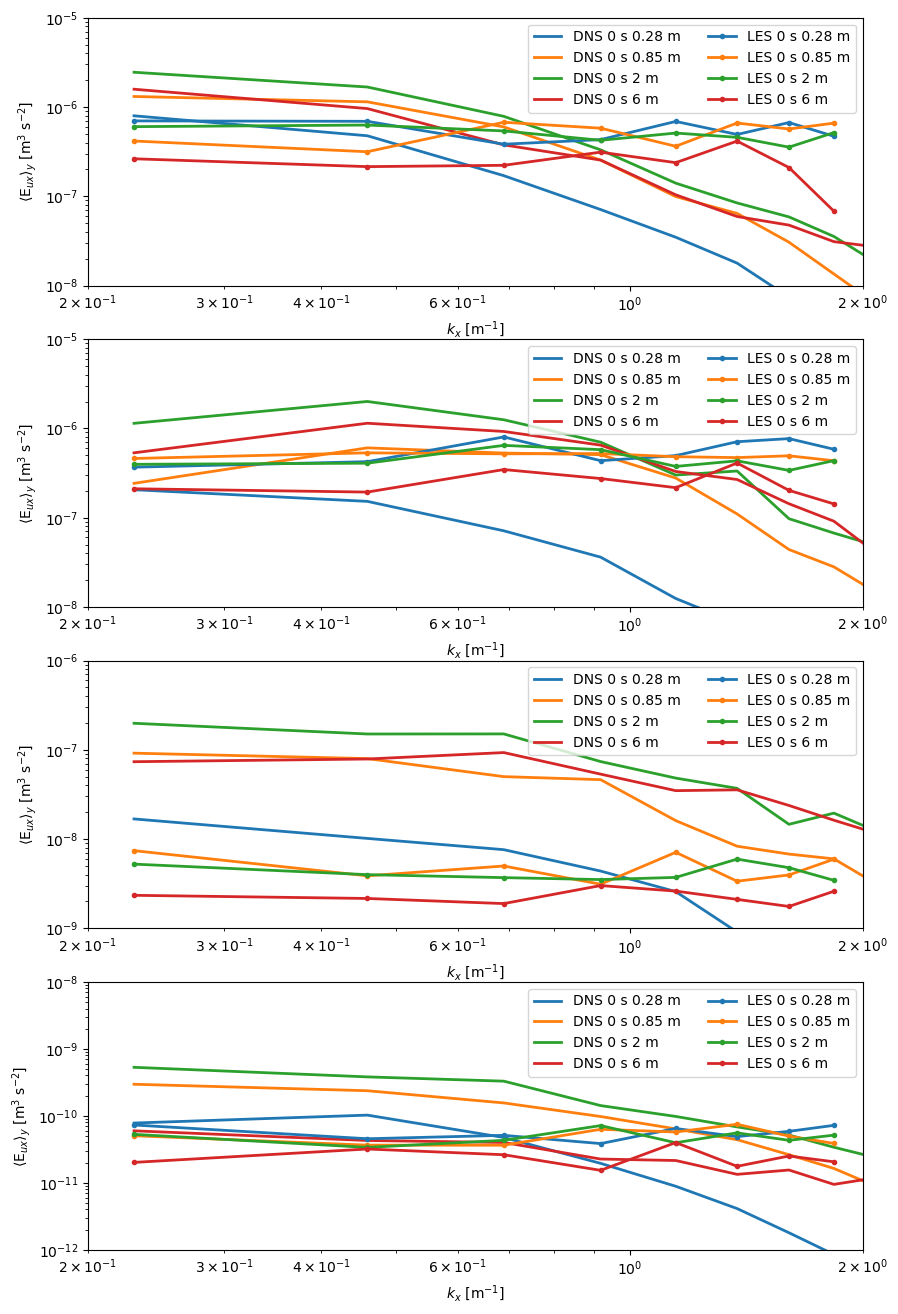

In [13]:
for i in range(len(axs)):
    axs[i].set_xlim([2e-1,2e0])
axs[0].set_ylim([1e-8,1e-5])
axs[1].set_ylim([1e-8,1e-5])
axs[2].set_ylim([1e-9,1e-6])
axs[3].set_ylim([1e-12,1e-8])
fig

In [6]:
# axs[0].set_ylim([1e-9,5e-8])
# axs[1].set_ylim([1e-9,7e-8])
# fig

In [7]:
# fig